In [1]:
import numpy as np
#import pandas as pd
import sklearn as skl
from hmmlearn import hmm
from scipy.misc import logsumexp
#import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set(rc={'text.usetex' : False})
%matplotlib inline

In [ ]:
DATA_DIR = '../data/trajdata_i101_trajectories-0750am-0805am/'
traj_lens = np.diff(np.loadtxt(DATA_DIR + 'traj_lengths.csv', dtype=np.int))

In [301]:
n_trajs = len(traj_lengths)
n_components = 5

In [ ]:
D = np.loadtxt(DATA_DIR + 'X_disc.csv', delimiter=',', dtype=np.int)

n_samples = D.shape[0]

obs = set()
for i in range(n_samples):
    obs.add(tuple(D[i]))

obs_lut = dict()
for (i, o) in enumerate(obs):
    obs_lut[o] = i

n_features = len(obs_lut)
X = np.apply_along_axis(lambda o: obs_lut[tuple(o)], axis=1, arr=D)
X = X[:, np.newaxis]

In [281]:
model = hmm.MultinomialHMM(n_components=n_components, n_iter=100)
model.n_features = n_features

In [282]:
model.fit(X, lengths=traj_lens)
loglike = model.monitor_.history[1]

C:\Users\Hamza El-Saawy\AppData\Roaming\Python\Python36\site-packages\hmmlearn\hmm.py:405: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T


MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=5,
        n_iter=100, params='ste',
        random_state=<mtrand.RandomState object at 0x000001285BA2E168>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

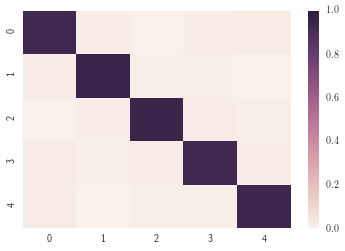

In [462]:
ax = sns.heatmap(model.transmat_, vmin=0, vmax=1)
ax.set(xlabel='x_{i+1}', ylabel='x_i')

In [ ]:
ax = sns.heatmap(model.emissionprob_, vmin=0, vmax=1)
ax.set(xlabel='x_{i+1}', ylabel='x_i')

In [440]:
for s, (i, j) in enumerate(hmm.iter_from_X_lengths(X, traj_lens)):
    # s is the trajectory number
    framelogprob = model._compute_log_likelihood(X[i:j])
    _, fwdlattice = model._do_forward_pass(framelogprob)
    bwdlattice = model._do_backward_pass(framelogprob)
    # skip the last timestep thingy
    temp = np.zeros((n_components, n_components))
    for t in range(j-i-1):
        temp = fwdlattice[t, :, np.newaxis] + model.transmat_ + bwdlattice[t+1] + framelogprob[t+1]
        temp -= logsumexp(temp)
        As[s] += np.exp(temp)
    As[s] /= As[s].sum(0, keepdims=True)

C:\Users\Hamza El-Saawy\AppData\Roaming\Python\Python36\site-packages\hmmlearn\hmm.py:405: RuntimeWarning: divide by zero encountered in log
  return np.log(self.emissionprob_)[:, np.concatenate(X)].T
